### Data Preprocessing - Importing Libraries and Loading Data

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
dataset = pd.read_csv(file_name)
print("Missing Values:\n", dataset.isnull().sum())

Saving dataset.csv to dataset (5).csv
Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### Data Preprocessing - Handling Missing Values and Splitting Data

In [50]:
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(dataset.iloc[:, :-1].values)
y = dataset.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Build & Train Improved ANN

In [51]:
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

initial_lr = 0.001
def lr_scheduler(epoch, lr):
    return initial_lr * np.exp(-0.01 * epoch)

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

class_weights = {0: 1.0, 1: 1.5}

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = ann.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop, LearningRateScheduler(lr_scheduler)],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.4119 - loss: 1.7541 - precision: 0.3477 - recall: 0.8530 - val_accuracy: 0.7398 - val_loss: 1.3835 - val_precision: 0.6032 - val_recall: 0.8444 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6234 - loss: 1.4496 - precision: 0.4582 - recall: 0.7089 - val_accuracy: 0.7642 - val_loss: 1.1424 - val_precision: 0.6481 - val_recall: 0.7778 - learning_rate: 9.9005e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7431 - loss: 1.2407 - precision: 0.6458 - recall: 0.6595 - val_accuracy: 0.7642 - val_loss: 0.9729 - val_precision: 0.7222 - val_recall: 0.5778 - learning_rate: 9.8020e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7428 - loss: 1.0892 - precision: 0.6598 - recall: 0.6750 - val_accuracy: 0.7642 - val_loss: 0.8411 - val_precision: 0.7500 - val_recall: 0.5333 - learning_rate: 9.7045e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7

### Evaluate Model

In [52]:
y_pred_proba = ann.predict(X_test)
y_pred = (y_pred_proba > 0.51).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nROC-AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_proba)))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8901    0.8182    0.8526        99
           1     0.7143    0.8182    0.7627        55

    accuracy                         0.8182       154
   macro avg     0.8022    0.8182    0.8077       154
weighted avg     0.8273    0.8182    0.8205       154


ROC-AUC: 0.8867

Confusion Matrix:
[[81 18]
 [10 45]]


### Plot Training History

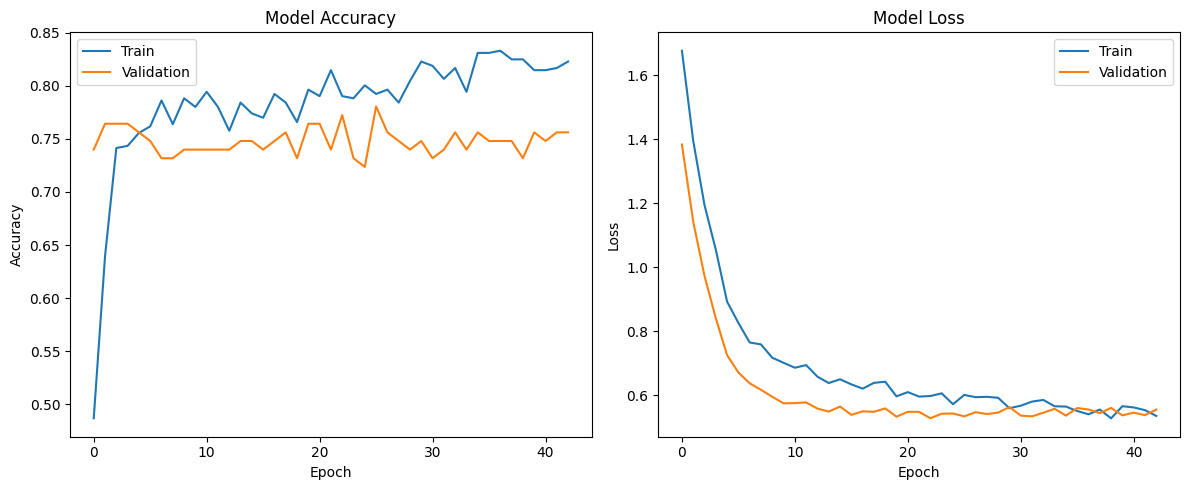

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Plot ROC Curve

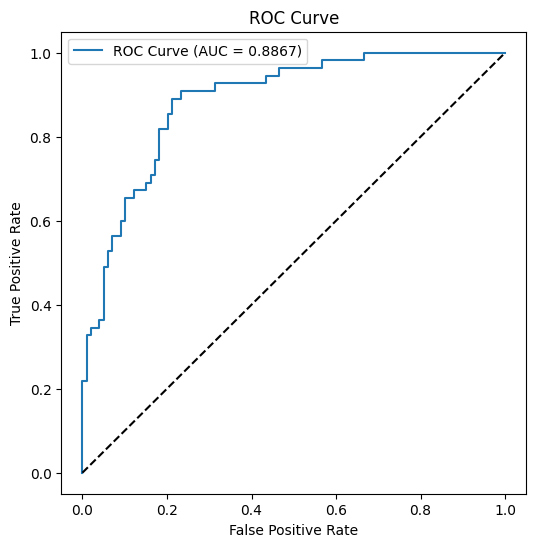

In [54]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Plot Normalized Confusion Matrix

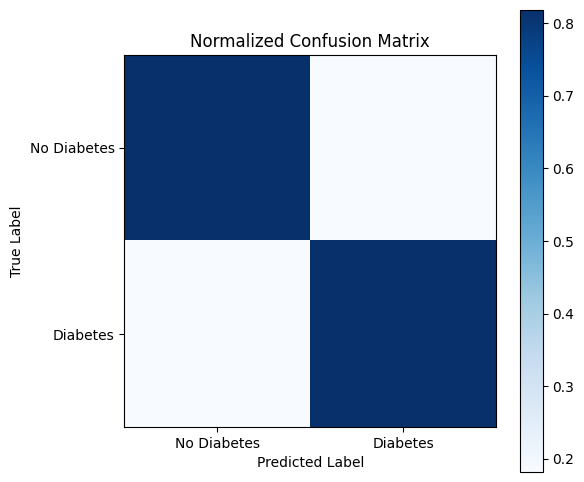

In [55]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.yticks([0, 1], ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

In [56]:
# import h5py
# ann.save('model.h5')
# files.download("model.h5")